# <center style="font-size: 40px; font-family: 'Arial', sans-serif; color: #4CAF50;">LSTMs for travel time Prediction</center>


# Data preprocessing

In [1]:
import pandas as pd

# Load the dataset
taxi_data = pd.read_csv('/workspaces/codespaces-jupyter/data/final_cleaned_taxi_data.csv')


In [2]:
taxi_data.columns

Index(['trip_start_timestamp', 'trip_end_timestamp', 'trip_duration_seconds',
       'trip_distance_miles', 'pickup_community_area',
       'dropoff_community_area', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

## Data  Filtering and  Aggregation

Before we proceed with modeling, it's essential to preprocess and aggregate our taxi trip data to ensure it's in the correct format and granularity. The function `aggregate_taxi_data` will help us achieve this by filtering the data based on specified months and community areas and then aggregating it to compute mean trip distances and durations.


In [2]:
import pandas as pd

def aggregate_taxi_data(taxi_data, months, focus_areas):
    """
    Preprocesses and aggregates taxi data based on specified months and community areas.

    Args:
    taxi_data (pd.DataFrame): The taxi trip data.
    months (list): List of integers representing the months to include in the analysis.
    focus_areas (list): List of integers representing the community areas to focus on.

    Returns:
    pd.DataFrame: Aggregated taxi data based on specified conditions.
    """

    # Ensure 'trip_start_timestamp' is in datetime format
    taxi_data['trip_start_timestamp'] = pd.to_datetime(taxi_data['trip_start_timestamp'])

    # Filter taxi_data for trips occurring in the specified months
    data_filtered = taxi_data[taxi_data['trip_start_timestamp'].dt.month.isin(months)]

    # Further filter to include only trips within the selected community areas
    data_filtered = data_filtered[(data_filtered['pickup_community_area'].isin(focus_areas)) & 
                                  (data_filtered['dropoff_community_area'].isin(focus_areas))]

    # Calculate quarter of the hour
    data_filtered['quarter_of_hour'] = data_filtered['trip_start_timestamp'].dt.minute // 15

    # Create a new timestamp that represents the start of the quarter hour
    data_filtered['trip_start_timestamp'] = data_filtered['trip_start_timestamp'].dt.floor('H') + \
        pd.to_timedelta(data_filtered['quarter_of_hour'] * 15, unit='min')

    # Group by location, community areas, and timestamp quarter of hour, and compute mean distance and duration
    aggregated_data = data_filtered.groupby([
        'trip_start_timestamp',
        'trip_end_timestamp',
        'pickup_community_area',
        'dropoff_community_area',
        'pickup_latitude', 
        'pickup_longitude', 
        'dropoff_latitude', 
        'dropoff_longitude', 
    ]).agg({
        'trip_distance_miles': 'mean',
        'trip_duration_seconds': 'mean'
    }).reset_index()


    return aggregated_data



In [3]:

# Filter taxi_data for trips occurring in the first 11 months of the year
months = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12] 
# Further filter to include only trips within the selected community areas
focus_areas = [6,7, 8, 32, 21,22,23,24,26,28, 27,28]  
aggregated_data = aggregate_taxi_data(taxi_data, months, focus_areas)

/tmp/ipykernel_13455/3727044613.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_filtered['trip_start_timestamp'] = data_filtered['trip_start_timestamp'].dt.floor('H') + \


In [5]:
# Display the aggregated data
aggregated_data.head()

,trip_start_timestamp,trip_end_timestamp,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,trip_duration_seconds
0,2023-01-01,2023-01-01 00:00:00,7.0,8.0,41.922686,-87.649489,41.899602,-87.633308,2.840000,511.200000
1,2023-01-01,2023-01-01 00:00:00,8.0,8.0,41.892042,-87.631864,41.895033,-87.619711,0.869970,156.594536
2,2023-01-01,2023-01-01 00:00:00,8.0,8.0,41.892508,-87.626215,41.890922,-87.618868,0.510539,91.896980
3,2023-01-01,2023-01-01 00:00:00,8.0,32.0,41.899602,-87.633308,41.878866,-87.625192,1.100000,198.000000
4,2023-01-01,2023-01-01 00:00:00,32.0,8.0,41.878866,-87.625192,41.899602,-87.633308,1.873948,337.310681


In [4]:
aggregated_data.shape

(1714302, 10)

## Feature Construction for Temporal Dependencies

To help the models capture temporal dependencies, we created new features from the `trip_start_timestamp` column. These features include the quarter of the hour, hour of the day, day of the week, and month of the year. This helps the model understand seasonality and trends across the year.

Rather than using one-hot encoding, which increases dimensionality, we used sine and cosine transformations to represent these cyclical features. This approach preserves the cyclical nature of time-related variables, allowing the model to understand that the end of a cycle is close to the beginning of the next cycle.


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    """
    # Convert trip_start_timestamp and trip_end_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
    df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

    # Extract hour of the day (cosine and sine)
    df['hour_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)

    # Extract day of the week (cosine and sine)
    df['day_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)
    df['day_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)

    
    # Extract quarter of the hour (cosine and sine)
    df['quarter_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    df['quarter_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1
    # Drop unnecessary columns
    df.drop(['trip_end_timestamp', 'pickup_community_area', 'dropoff_community_area'], axis=1, inplace=True)

    return df

# Example usage
# Assuming 'df' is your original DataFrame
# 


In [33]:
prepared_df = prepare_dataset(aggregated_data)

In [8]:
prepared_df.columns

Index(['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'trip_distance_miles',
       'trip_duration_seconds', 'hour_cos', 'hour_sin', 'day_cos', 'day_sin',
       'quarter_cos', 'quarter_sin', 'is_weekend', 'is_morning_rush',
       'is_evening_rush'],
      dtype='object')

In [8]:
prepared_df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,trip_duration_seconds,hour_cos,hour_sin,day_cos,day_sin,quarter_cos,quarter_sin,is_weekend,is_morning_rush,is_evening_rush
0,2023-01-01,41.922686,-87.649489,41.899602,-87.633308,2.840000,511.200000,1.0,0.0,1.0,-2.449294e-16,1.0,0.0,1,0,0
1,2023-01-01,41.892042,-87.631864,41.895033,-87.619711,0.869970,156.594536,1.0,0.0,1.0,-2.449294e-16,1.0,0.0,1,0,0
2,2023-01-01,41.892508,-87.626215,41.890922,-87.618868,0.510539,91.896980,1.0,0.0,1.0,-2.449294e-16,1.0,0.0,1,0,0
3,2023-01-01,41.899602,-87.633308,41.878866,-87.625192,1.100000,198.000000,1.0,0.0,1.0,-2.449294e-16,1.0,0.0,1,0,0
4,2023-01-01,41.878866,-87.625192,41.899602,-87.633308,1.873948,337.310681,1.0,0.0,1.0,-2.449294e-16,1.0,0.0,1,0,0


# Model Training and Evaluation Pipeline

In this section, we will outline the key components required for training and evaluating our model. These components include:

1. **Window Generator Class:** A class to handle the creation of input and output windows for the time series data.
2. **Model Function:** A function to define and compile the designed LSTM model.
3. **Training Function:** A function to train the model using the generated windows.
4. **Evaluation Function:** A function to evaluate the model's performance on the test data.
5. **Creation of Windows:** The process of creating input and output windows for model training and evaluation.


#### **Window generator class**

Due to the complex nature of our data and the varying lengths of sequences at each timestep, we used a custom approach in the window generator class. 

The `TaxiTripWindowGenerator` class is designed to preprocess the data, scale the features and targets, and generate input and output windows for the time series data, facilitating the training process of the model.

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

class TaxiTripWindowGenerator:
    def __init__(self, input_width, label_column='trip_duration_seconds'):
        self.input_width = input_width
        self.label_column = label_column
        self.feature_scaler = StandardScaler()  # Scaler for features
        self.target_scaler = StandardScaler()   # Separate scaler for the target

    def fit_scaler(self, train_data):
        # Fit the feature scaler only on training data feature columns
        feature_columns = [col for col in train_data.columns if col != self.label_column and col != 'trip_start_timestamp']
        self.feature_scaler.fit(train_data[feature_columns])
        # Fit the target scaler only on the target column in the training data
        self.target_scaler.fit(train_data[[self.label_column]])

    def transform_data(self, data):
        # Apply the feature scaler on data feature columns
        feature_columns = [col for col in data.columns if col != self.label_column and col != 'trip_start_timestamp']
        data[feature_columns] = self.feature_scaler.transform(data[feature_columns])
        # Apply the target scaler on the target column
        data[self.label_column] = self.target_scaler.transform(data[[self.label_column]])
        return data

    def make_dataset(self, data, shuffle=True):
        # Sort data by timestamp to maintain chronological order
        data = data.sort_values('trip_start_timestamp')
        # Normalize features and target
        data = self.transform_data(data)

        sequence_data = []
        targets = []
        
        grouped = data.groupby('trip_start_timestamp')
        for _, group in grouped:
            if len(group) >= self.input_width:
                for start_idx in range(len(group) - self.input_width + 1):
                    end_idx = start_idx + self.input_width
                    feature_columns = [col for col in group.columns if col != self.label_column and col != 'trip_start_timestamp']
                    sequence_data.append(group.iloc[start_idx:end_idx][feature_columns].values)
                    # Reshape targets to ensure the extra dimension for TimeDistributed
                    target_data = group.iloc[start_idx:end_idx][self.label_column].values.reshape(-1, 1)
                    targets.append(target_data)
        
        sequence_data = np.array(sequence_data, dtype=np.float32)
        targets = np.array(targets, dtype=np.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((sequence_data, targets))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100)
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
        
        return dataset

    def prepare_data(self, df):
        # Split the DataFrame into training, validation, and testing sets
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
        
        # Fit scaler only on training data
        self.fit_scaler(train_df)

        # Create datasets
        train_data = self.make_dataset(train_df)
        val_data = self.make_dataset(val_df, shuffle=False)
        test_data = self.make_dataset(test_df, shuffle=False)
        
        return train_data, val_data, test_data


### Model training: Implement Learning Rate Scheduler and Early Stopping
Modify the training function to include a learning rate scheduler which can dynamically adjust the learning rate during training, and ensure we have early stopping to prevent overfitting.

In [18]:
def train_model(model, train_data, val_data, epochs=30, batch_size=32):
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    # Learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001, verbose=1)

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, lr_scheduler],  # Add lr_scheduler to callbacks
        verbose=1
    )
    
    return history


### Model Evaluation

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_predictions_with_visualization(model, dataset, target_scaler, sample_size=100, evaluation_metrics=('mse', 'mae', 'rmse', 'r2')):
    """
    Evaluate the model predictions on a sample of the dataset using specified evaluation metrics and visualize the results.
    This function also plots the true values vs. the predicted values.

    Args:
        model: Trained model to evaluate.
        dataset: Dataset to evaluate the model on.
        target_scaler: Scaler used to transform the target variable.
        sample_size: Number of observations to sample from the dataset.
        evaluation_metrics: Tuple of evaluation metrics to compute. Supported metrics: 'mse', 'mae', 'rmse', 'r2'.

    Returns:
        Dictionary containing the evaluation results for each metric.
    """
    evaluation_results = {}
    predictions = []
    true_values = []

    # Sample a subset of the dataset
    dataset = dataset.take(sample_size)

    for x, y_true in dataset:
        y_pred = model.predict(x)
        predictions.append(y_pred)
        true_values.append(y_true)

    # Flatten the predictions and true values for evaluation and visualization
    predictions = np.vstack(predictions).flatten()
    true_values = np.vstack(true_values).flatten()

    # Inverse transform the predictions and true values to original scale
    predictions_original_scale = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    true_values_original_scale = target_scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()

    # Calculate each specified metric on the original scale
    if 'mse' in evaluation_metrics:
        mse = tf.keras.losses.MeanSquaredError()(true_values_original_scale, predictions_original_scale).numpy()
        evaluation_results['mse'] = mse
    if 'mae' in evaluation_metrics:
        mae = tf.keras.losses.MeanAbsoluteError()(true_values_original_scale, predictions_original_scale).numpy()
        evaluation_results['mae'] = mae
    if 'rmse' in evaluation_metrics:
        rmse = np.sqrt(tf.keras.losses.MeanSquaredError()(true_values_original_scale, predictions_original_scale).numpy())
        evaluation_results['rmse'] = rmse
    if 'r2' in evaluation_metrics:
        r2 = r2_score(true_values_original_scale, predictions_original_scale)
        evaluation_results['r2'] = r2

    # Print the metrics for the user
    for metric, value in evaluation_results.items():
        print(f"{metric.upper()}: {value:.4f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(true_values_original_scale, label='True Values', alpha=0.7)
    plt.plot(predictions_original_scale, label='Predictions', alpha=0.7)
    plt.title('Comparison of Predictions and True Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return evaluation_results


### Prepare the data for training and evaluation

In [37]:
# # Initialize the window generator
input_width = 8  # This is the number of timesteps per input sequence
window_generator = TaxiTripWindowGenerator(input_width=input_width)

# Prepare the data using the method in the class
train_data2, val_data2, test_data2 = window_generator.prepare_data(prepared_df)

**Save the fitted  scalers**
We will save  the fitted scalers, so they don't need to be refit every time the data preparation process is run. This could be particularly useful since we are working with large dataset and the scaling parameters are important for reproducing results.

In [13]:
import joblib
joblib.dump(window_generator.feature_scaler, '/workspaces/codespaces-jupyter/notebooks/vanilla_LSTM/feature_scaler_FV_2.pkl')

['/workspaces/codespaces-jupyter/notebooks/vanilla_LSTM/feature_scaler_FV_2.pkl']

In [14]:
joblib.dump(window_generator.target_scaler, '/workspaces/codespaces-jupyter/notebooks/vanilla_LSTM/target_scaler_FV_2.pkl')

['/workspaces/codespaces-jupyter/notebooks/vanilla_LSTM/target_scaler_FV_2.pkl']

## Model Creation and training

### **Vanilla LSTM**

**Create the vanilla model**

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(input_width, len(prepared_df.columns) - 2)),  #  - 2 excludes 'trip_duration_seconds' and 'trip_start_timestamp'
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history1 = model.fit(train_data2, validation_data=val_data2, epochs=10)

Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25803/25803 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - loss: 0.0247 - val_loss: 5.0529e-05
Epoch 2/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 4.9540e-05 - val_loss: 5.0211e-05
Epoch 3/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 3.8054e-05 - val_loss: 7.9395e-05
Epoch 4/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 2.3916e-05 - val_loss: 2.6600e-05
Epoch 5/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 2.3086e-05 - val_loss: 3.8453e-05
Epoch 6/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 2.0488e-05 - val_loss: 1.2466e-05
Epoch 7/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 1.6107e-05 - val_loss: 1.9724e-05
Epoch 8/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 1.6297e-05 - val_loss: 1.8225e-05
Epoch 9/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 1.4434e-05 - val_loss: 1.4797e-05
Epoch 10/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 1.4723e-05 - val_loss: 1.6997e-05


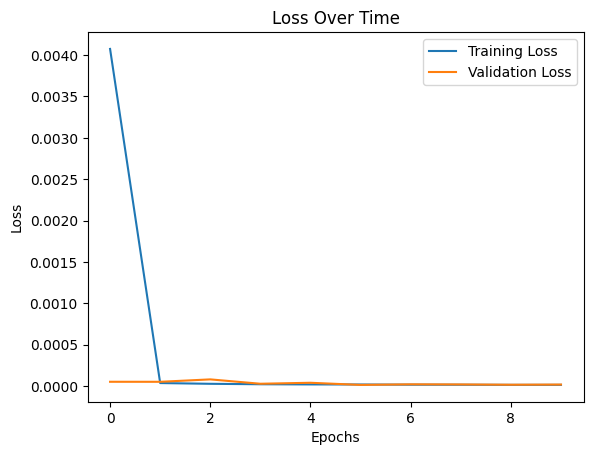

In [39]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

2024-06-16 12:28:48.298597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


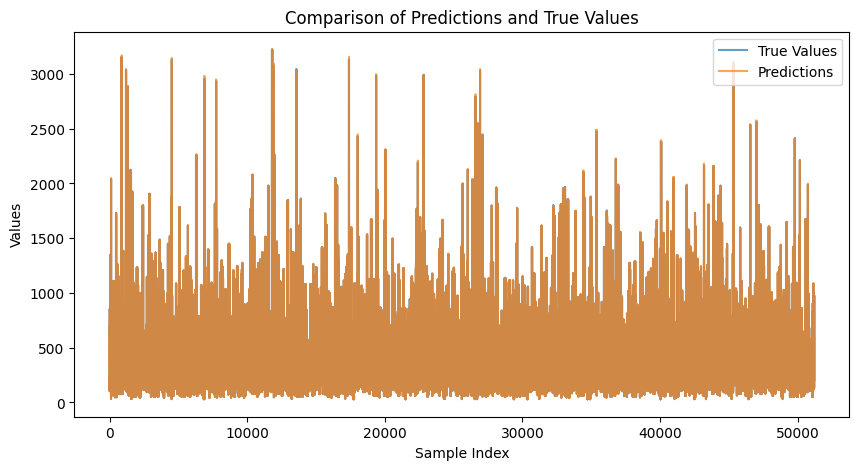

In [41]:
# Evaluate and visualize
results = evaluate_predictions_with_visualization(model, test_data2,window_generator.target_scaler)


In [22]:
model.save('/workspaces/codespaces-jupyter/notebooks/vanilla_LSTM/vanilla_lstm_model.h5') 

________________



## Time series bidirectionnnal Lstm
Our LSTM model is designed to tackle the challenging task of predicting taxi trip durations. Leveraging the power of Long Short-Term Memory networks, this model is capable of capturing long-term dependencies in the data, which is crucial for time series forecasting tasks like ours.

The core of our model is a Stacked LSTM architecture, which consists of:

- **Bidirectional LSTM Layers**: These layers process the input data in both forward and backward directions, enabling the model to capture patterns from both past and future states. This is particularly beneficial for time series data, where future states can influence current ones.

- **Dropout Layers**: To prevent overfitting, we incorporate Dropout layers after each LSTM layer. These randomly drop out neurons during training, forcing the model to learn more robust features.

- **TimeDistributed Dense Layer**: Finally, a TimeDistributed layer wraps around a Dense layer, allowing us to apply the Dense layer to each timestep of the input sequence independently. This setup is essential for generating a prediction for each timestep in our sequence data.

### Key Components

- **Input Shape**: The model expects input data shaped according to the dimensions required by the LSTM layers, typically `[samples, timesteps, features]`.

- **Learning Rate**: We use an Adam optimizer with a learning rate of 0.001, adjusted for gradient clipping to stabilize training.

- **Loss Function**: The Mean Squared Error (MSE) loss function is chosen for its suitability in regression problems, aiming to minimize the squared differences between predicted and actual values.

- **Metrics**: Besides the loss, we monitor the Mean Absolute Error (MAE) as an additional metric to evaluate the model's performance.

This model is a testament to the effectiveness of LSTM architectures in handling time-dependent data, offering a promising approach to improving taxi trip duration predictions.


In [17]:
from tensorflow.keras.optimizers import Adam

def create_ts_bilstm_model(input_shape, units=128, learning_rate=0.001, loss='mse', dropout_rate=0.3):
    # Include gradient clipping in the optimizer
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)

    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True, activation='relu'), input_shape=input_shape),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(units, return_sequences=True, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    
    return model


### Train the model

In [43]:
model = create_ts_bilstm_model(input_shape=(8, 14), units=128, learning_rate=0.001, dropout_rate=0.3)
history = train_model(model, train_data2, val_data2, epochs=10, batch_size=32)


Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25803/25803 ━━━━━━━━━━━━━━━━━━━━ 370s 14ms/step - loss: 0.0312 - mae: 0.0917 - val_loss: 0.0010 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 2/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 359s 14ms/step - loss: 0.0099 - mae: 0.0583 - val_loss: 8.6823e-04 - val_mae: 0.0141 - learning_rate: 0.0010
Epoch 3/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 355s 14ms/step - loss: 0.0094 - mae: 0.0567 - val_loss: 9.9324e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 4/10
25801/25803 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092 - mae: 0.0562
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 358s 14ms/step - loss: 0.0092 - mae: 0.0562 - val_loss: 0.0013 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 5/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 355s 14ms/step - loss: 0.0084 - mae: 0.0530 - val_loss: 3.0640e-04 - val_mae: 0.0083 - learning_rate: 1.0000e-04
Epoch 6/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 357s 14ms/step - loss: 0.0081 - mae: 0.0523 - val_loss

### Plot the training and validation loss

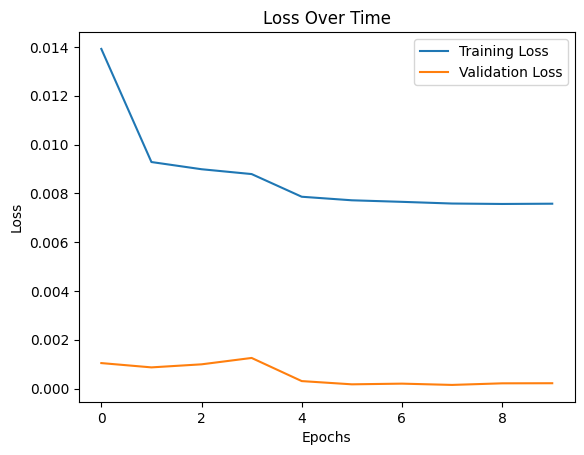

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()


## Evaluate the results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

2024-06-16 13:34:24.994665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


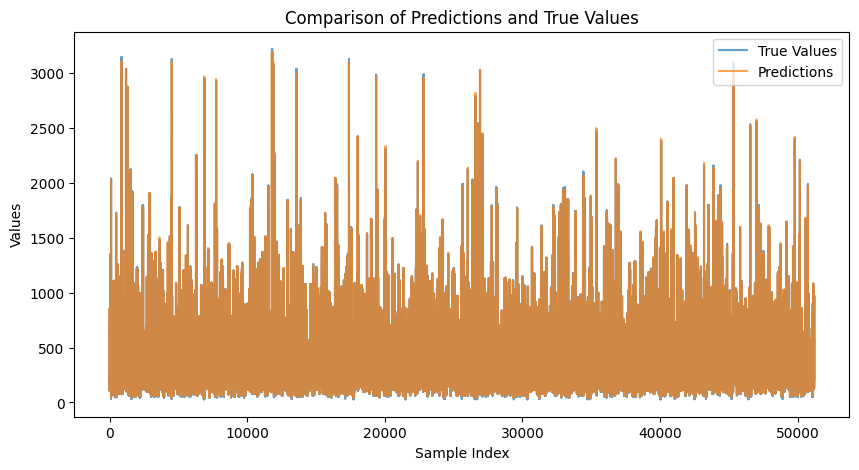

In [50]:
# Evaluate and visualize
results = evaluate_predictions_with_visualization(model, test_data2,window_generator.target_scaler,sample_size=200)


### **Save the model**

In [14]:
model.save('/workspaces/codespaces-jupyter/notebooks/LSTMs/enhanced_lstm/Model_and_Scalers/final_ts_bilstm_model.h5') 

# Predicting Travel Times and Generating Updated Matrices

With our LSTM model trained and validated, we now turn our attention to its practical application. Our goal is to leverage the model's predictive capabilities to forecast travel times for a representative sample of trips between 30 distinct locations. These forecasts will serve as the foundation for updating travel time matrices, providing valuable insights for transportation planning and optimization.

## Step 1: Preparing Sample Trip Data
To begin, we select a sample of trip records from our dataset, focusing on trips originating or terminating at any of the 30 designated locations. This sample ensures that our predictions are relevant and applicable to the specific geographical area of interest.

In [65]:
import pandas as pd
taxi_trips=pd.read_csv("/workspaces/codespaces-jupyter/data/generated_test_d_xgb/predicted_distance__generated_trips.csv")

In [66]:
taxi_trips.shape

(20880, 7)

In [69]:
taxi_trips.columns

Index(['Unnamed: 0', 'trip_start_timestamp', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
       'trip_distance_miles'],
      dtype='object')

In [70]:
taxi_trips.drop(columns=['Unnamed: 0'], inplace=True)

In [59]:
taxi_trips.head(10)

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles
0,2023-12-02 08:00:00,41.93476,-87.639854,41.900223,-87.629105,3.042091
1,2023-12-02 08:00:00,41.93476,-87.639854,41.911972,-87.683640,3.759552
2,2023-12-02 08:00:00,41.93476,-87.639854,41.878864,-87.625190,4.643526
3,2023-12-02 08:00:00,41.93476,-87.639854,41.929047,-87.651310,2.300505
4,2023-12-02 08:00:00,41.93476,-87.639854,41.899590,-87.674720,4.099584
5,2023-12-02 08:00:00,41.93476,-87.639854,41.914750,-87.654010,2.808686
6,2023-12-02 08:00:00,41.93476,-87.639854,41.898330,-87.620766,3.164725
7,2023-12-02 08:00:00,41.93476,-87.639854,41.929077,-87.646290,2.202451
8,2023-12-02 08:00:00,41.93476,-87.639854,41.942870,-87.701330,4.988637
9,2023-12-02 08:00:00,41.93476,-87.639854,41.946490,-87.647110,2.289286


In [71]:
# Filter the dataframe based on specified column values
pickup_lat = 41.863422
pickup_long = -87.653755
dropoff_lat = 41.870415
dropoff_long = -87.67509

filtered_df = taxi_trips[
    (taxi_trips['pickup_latitude'] == pickup_lat) &
    (taxi_trips['pickup_longitude'] == pickup_long) &
    (taxi_trips['dropoff_latitude'] == dropoff_lat) &
    (taxi_trips['dropoff_longitude'] == dropoff_long)
]



In [72]:
filtered_df.shape

(24, 6)

In [73]:
filtered_df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles
776,2023-12-02 08:00:00,41.863422,-87.653755,41.870415,-87.67509,3.200388
1646,2023-12-02 08:15:00,41.863422,-87.653755,41.870415,-87.67509,3.174039
2516,2023-12-02 08:30:00,41.863422,-87.653755,41.870415,-87.67509,3.167853
3386,2023-12-02 08:45:00,41.863422,-87.653755,41.870415,-87.67509,3.175905
4256,2023-12-02 09:00:00,41.863422,-87.653755,41.870415,-87.67509,3.256637


**Function to prepare the data**
This function is simillar to the one we used for the training data.

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    """
    # Convert trip_start_timestamp and trip_end_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

    # Extract hour of the day (cosine and sine)
    df['hour_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)

    # Extract day of the week (cosine and sine)
    df['day_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)
    df['day_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)

    
    # Extract quarter of the hour (cosine and sine)
    df['quarter_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    df['quarter_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1
    # # Drop unnecessary columns
    # df.drop(['trip_end_timestamp', 'pickup_community_area', 'dropoff_community_area'], axis=1, inplace=True)

    return df


In [75]:
prepared_df = prepare_dataset(taxi_trips)

In [77]:
prepared_df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,hour_cos,hour_sin,day_cos,day_sin,quarter_cos,quarter_sin,is_weekend,is_morning_rush,is_evening_rush
0,2023-12-02 08:00:00,41.93476,-87.639854,41.900223,-87.629105,3.042091,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0
1,2023-12-02 08:00:00,41.93476,-87.639854,41.911972,-87.683640,3.759552,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0
2,2023-12-02 08:00:00,41.93476,-87.639854,41.878864,-87.625190,4.643526,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0
3,2023-12-02 08:00:00,41.93476,-87.639854,41.929047,-87.651310,2.300505,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0
4,2023-12-02 08:00:00,41.93476,-87.639854,41.899590,-87.674720,4.099584,-0.5,0.866025,0.5,-0.866025,1.0,0.0,1,1,0


### Window generator class for predictions
We will create  a separate class specifically designed for preparing data for predictions. Similar to the window generator we used for training, this class organizes data into sequences. However, it uniquely segregates the timestamps into a separate array. This agregation facilitates the post-prediction merging of timestamps with the forecasted data, ensuring each prediction is accurately associated with its original timeframe.

In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

class PredictionDataPreparer:
    def __init__(self, feature_scaler, target_scaler, input_width):
        """
        Initializes the PredictionDataPreparer class with given scalers and input width.
        
        Args:
        feature_scaler (StandardScaler): The scaler used to normalize features, already fitted to the training data.
        target_scaler (StandardScaler): The scaler used to normalize the target variable, already fitted to the training data.
        input_width (int): The number of timesteps each input sequence should contain.
        """
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.input_width = input_width

    def prepare_data(self, data):
        """
        Prepares the data for prediction by scaling features and target, and converting data into a suitable format for the model.
        
        Args:
        data (pd.DataFrame): The preprocessed data to be prepared for prediction.
        
        Returns:
        tuple: A tuple containing the data ready for prediction (as sequences), the corresponding timestamps, and the scaled target.
        """
        # Extract the trip_start_timestamp column
        timestamps = data['trip_start_timestamp'].values
        
        # Define feature columns and target column
        feature_columns = [col for col in data.columns if col not in ['trip_start_timestamp']]

        
        # Apply the feature scaler on feature columns
        data[feature_columns] = self.feature_scaler.transform(data[feature_columns])
        

        
        # Create sequences of the required input width
        sequence_data = []
        sequence_timestamps = []
        sequence_target = []
        if len(data) >= self.input_width:
            for start_idx in range(len(data) - self.input_width + 1):
                end_idx = start_idx + self.input_width
                sequence_data.append(data.iloc[start_idx:end_idx][feature_columns].values)
                sequence_timestamps.append(timestamps[start_idx:end_idx])


        sequence_data = np.array(sequence_data, dtype=np.float32)
        sequence_timestamps = np.array(sequence_timestamps)
        
        return sequence_data, sequence_timestamps


### Load the fitted scalers 

In [79]:
from joblib import load

feature_scaler = load('/workspaces/codespaces-jupyter/notebooks/best_model/feature_scaler_FV_2.pkl')
target_scaler = load('/workspaces/codespaces-jupyter/notebooks/best_model/target_scaler_FV_2.pkl')


### Prepare the data

In [80]:
preparer = PredictionDataPreparer(feature_scaler,target_scaler,input_width=8)
prepared_data, prepared_timestamps = preparer.prepare_data(prepared_df)

## Step 2: Model Inference

### Load the model

In [ ]:
# pip install tensorflow

In [81]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the model and explicitly define 'mse' if it's unrecognized
model = load_model('/workspaces/codespaces-jupyter/notebooks/best_model/Improved_LSTM_model_11_M.h5', custom_objects={'mse': MeanSquaredError()})


### Predict the travel times


In [82]:
predictions = model.predict(prepared_data)

653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [83]:
#  tensor with the scaled predicted travel times
predictions

array([[[0.54872674],
        [0.981926  ],
        [1.5047096 ],
        ...,
        [0.41048154],
        [0.6260175 ],
        [0.04352029]],

       [[0.9782645 ],
        [1.5113561 ],
        [0.10563309],
        ...,
        [0.62275535],
        [0.04747248],
        [1.7279973 ]],

       [[1.5052851 ],
        [0.10395197],
        [1.1788522 ],
        ...,
        [0.04515758],
        [1.7199751 ],
        [0.09470014]],

       ...,

       [[2.0986261 ],
        [1.9676756 ],
        [0.58189327],
        ...,
        [1.0085927 ],
        [0.8569318 ],
        [2.19808   ]],

       [[1.9674085 ],
        [0.5912857 ],
        [2.4407923 ],
        ...,
        [0.8537556 ],
        [2.1862576 ],
        [2.3362043 ]],

       [[0.5808769 ],
        [2.4361622 ],
        [0.6700057 ],
        ...,
        [2.1863015 ],
        [2.336277  ],
        [0.80597806]]], dtype=float32)

Rescale the prediction to their original scale

In [84]:
# Flatten the 3D predictions to 2D
predictions_reshaped = predictions.reshape(-1, predictions.shape[2])

# Apply inverse scaling
original_scale_predictions = target_scaler.inverse_transform(predictions_reshaped)

# Optionally reshape back to 3D if needed for further processing
original_scale_predictions = original_scale_predictions.reshape(predictions.shape)
original_scale_predictions

array([[[ 547.62146],
        [ 678.986  ],
        [ 837.51636],
        ...,
        [ 505.69962],
        [ 571.0593 ],
        [ 394.42126]],

       [[ 677.8757 ],
        [ 839.53186],
        [ 413.25653],
        ...,
        [ 570.0701 ],
        [ 395.61975],
        [ 905.22675]],

       [[ 837.69086],
        [ 412.74673],
        [ 738.70245],
        ...,
        [ 394.91776],
        [ 902.79407],
        [ 409.9412 ]],

       ...,

       [[1017.61725],
        [ 977.9074 ],
        [ 557.67896],
        ...,
        [ 687.0725 ],
        [ 641.0824 ],
        [1047.7759 ]],

       [[ 977.8265 ],
        [ 560.52716],
        [1121.3766 ],
        ...,
        [ 640.11926],
        [1044.1908 ],
        [1089.6611 ]],

       [[ 557.3708 ],
        [1119.9727 ],
        [ 584.39844],
        ...,
        [1044.2041 ],
        [1089.6831 ],
        [ 625.63104]]], dtype=float32)

Rescale the features to their original scale and merge them with the predicted travel times and the array wontaining the timestamps

In [85]:
# Flatten the 3D predictions to 2D
predictions_reshaped = predictions.reshape(-1, predictions.shape[2])

# Apply inverse scaling to predictions
original_scale_predictions = target_scaler.inverse_transform(predictions_reshaped)

# Optionally reshape back to 3D if needed for further processing
original_scale_predictions = original_scale_predictions.reshape(predictions.shape)

# Reshape prepared_data for inverse transformation (flatten the timesteps for simplicity)
num_samples, num_timesteps, num_features = prepared_data.shape
flat_prepared_data = prepared_data.reshape(-1, num_features)

# Reverse normalization of features
original_scale_features = feature_scaler.inverse_transform(flat_prepared_data)

# Reshape back to original dimensions
original_scale_features = original_scale_features.reshape(num_samples, num_timesteps, num_features)

# Flatten the original_scale_features and original_scale_predictions for DataFrame creation
flat_data = original_scale_features.reshape(-1, num_features)  # Reshape to (num_samples * num_timesteps, num_features)
flat_predictions = original_scale_predictions.reshape(-1, 1)  # Reshape to (num_samples * num_timesteps, 1)

# Convert to pandas DataFrames
feature_names = [
    'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
    'trip_distance_miles', 'hour_cos', 'hour_sin', 'day_cos', 'day_sin',
    'quarter_cos', 'quarter_sin', 'is_weekend', 'is_morning_rush', 'is_evening_rush'
]
data_df = pd.DataFrame(flat_data, columns=feature_names)
predictions_df = pd.DataFrame(flat_predictions, columns=['predicted_trip_duration_seconds'])

# Flatten and repeat timestamps to match the shape of flat_data and flat_predictions
flat_timestamps = prepared_timestamps.reshape(-1)  # Flatten the 2D array to 1D

# Add the timestamps to the data DataFrame
data_df['trip_start_timestamp'] = flat_timestamps

# Concatenate dataframes
final_df = pd.concat([data_df, predictions_df], axis=1)

In [86]:
import pandas as pd

desired_order = [
    'trip_start_timestamp',
    'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
    'trip_distance_miles', 'hour_cos', 'hour_sin', 'day_cos', 'day_sin',
    'quarter_cos', 'quarter_sin', 'is_weekend', 'is_morning_rush', 'is_evening_rush',
    'predicted_trip_duration_seconds'
]

# Reindex the DataFrame to reflect the desired column order
final_df = final_df[desired_order]


In [101]:
final_df.tail()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,hour_cos,hour_sin,day_cos,day_sin,quarter_cos,quarter_sin,is_weekend,is_morning_rush,is_evening_rush,predicted_trip_duration_seconds,quarter_of_hour
166979,2023-12-02 13:45:00,41.936157,-87.661263,41.901207,-87.676353,3.818757,-0.965926,-0.258819,0.5,-0.866025,1.0,-7.347881e-16,1.0,1.217376e-09,-4.942907e-09,686.391357,3
166980,2023-12-02 13:45:00,41.936157,-87.661263,41.912434,-87.670189,3.548749,-0.965926,-0.258819,0.5,-0.866025,1.0,-7.347881e-16,1.0,1.217376e-09,-4.942907e-09,640.068542,3
166981,2023-12-02 13:45:00,41.936157,-87.661263,41.863422,-87.653755,5.866151,-0.965926,-0.258819,0.5,-0.866025,1.0,-7.347881e-16,1.0,1.217376e-09,-4.942907e-09,1044.204102,3
166982,2023-12-02 13:45:00,41.936157,-87.661263,41.900070,-87.720917,6.126247,-0.965926,-0.258819,0.5,-0.866025,1.0,-7.347881e-16,1.0,1.217376e-09,-4.942907e-09,1089.683105,3
166983,2023-12-02 13:45:00,41.936157,-87.661263,41.921879,-87.664078,3.473943,-0.965926,-0.258819,0.5,-0.866025,1.0,-7.347881e-16,1.0,1.217376e-09,-4.942907e-09,625.631042,3


In [88]:
final_df.shape

(166984, 16)

In [93]:
import pandas as pd

def aggregate_taxi_data(data_filtered):
    """
    Preprocesses and aggregates taxi data based on specified months and community areas.

    Args:
    taxi_data (pd.DataFrame): The taxi trip data.
    months (list): List of integers representing the months to include in the analysis.
    focus_areas (list): List of integers representing the community areas to focus on.

    Returns:
    pd.DataFrame: Aggregated taxi data based on specified conditions.
    """

    # Ensure 'trip_start_timestamp' is in datetime format
    data_filtered['trip_start_timestamp'] = pd.to_datetime(data_filtered['trip_start_timestamp'])


    # Calculate quarter of the hour
    data_filtered['quarter_of_hour'] = data_filtered['trip_start_timestamp'].dt.minute // 15

    # Create a new timestamp that represents the start of the quarter hour
    data_filtered['trip_start_timestamp'] = data_filtered['trip_start_timestamp'].dt.floor('H') + \
        pd.to_timedelta(data_filtered['quarter_of_hour'] * 15, unit='min')

    # Group by location, community areas, and timestamp quarter of hour, and compute mean distance and duration
    aggregated_data = data_filtered.groupby([
        'trip_start_timestamp',
        'pickup_latitude', 
        'pickup_longitude', 
        'dropoff_latitude', 
        'dropoff_longitude', 
        'trip_distance_miles'

    ]).agg({
        'predicted_trip_duration_seconds': 'mean'
    }).reset_index()


    return aggregated_data



In [94]:
aggregated_data=aggregate_taxi_data(final_df)

/tmp/ipykernel_2206/681322431.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_filtered['trip_start_timestamp'] = data_filtered['trip_start_timestamp'].dt.floor('H') + \


Save the predicted trips

In [95]:
aggregated_data.shape

(20880, 7)

In [105]:
aggregated_data.to_csv('/workspaces/codespaces-jupyter/data/generated_test_d_xgb/predicted_trips.csv', index=False)

In [102]:
# Filter the dataframe based on specified column values
pickup_lat = 41.936157
pickup_long = -87.661263
dropoff_lat = 41.912434
dropoff_long = -87.670189

filtered_df = aggregated_data[
    (aggregated_data['pickup_latitude'] == pickup_lat) &
    (aggregated_data['pickup_longitude'] == pickup_long) &
    (aggregated_data['dropoff_latitude'] == dropoff_lat) &
    (aggregated_data['dropoff_longitude'] == dropoff_long)
]



In [103]:
filtered_df.shape

(24, 7)

In [99]:
filtered_df.columns

Index(['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'trip_distance_miles',
       'predicted_trip_duration_seconds'],
      dtype='object')

In [104]:
filtered_df

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,predicted_trip_duration_seconds
768,2023-12-02 08:00:00,41.936157,-87.661263,41.912434,-87.670189,3.509045,633.403198
1638,2023-12-02 08:15:00,41.936157,-87.661263,41.912434,-87.670189,3.492592,630.906616
2508,2023-12-02 08:30:00,41.936157,-87.661263,41.912434,-87.670189,3.491709,631.424377
3378,2023-12-02 08:45:00,41.936157,-87.661263,41.912434,-87.670189,3.483861,628.833801
4248,2023-12-02 09:00:00,41.936157,-87.661263,41.912434,-87.670189,3.539328,638.373779
5118,2023-12-02 09:15:00,41.936157,-87.661263,41.912434,-87.670189,3.536843,638.152710
5988,2023-12-02 09:30:00,41.936157,-87.661263,41.912434,-87.670189,3.536700,638.612549
6858,2023-12-02 09:45:00,41.936157,-87.661263,41.912434,-87.670189,3.534339,637.619080
7728,2023-12-02 10:00:00,41.936157,-87.661263,41.912434,-87.670189,3.582214,645.921387
8598,2023-12-02 10:15:00,41.936157,-87.661263,41.912434,-87.670189,3.569200,643.853394


In [108]:
final_df=aggregated_data.copy()

## Step 3: Generating Travel Time Matrices

### 1. Generate Unique Indexes for Each Location

The resulting matrices will be of size 31x31, reflecting the 30 unique locations. These matrices will incorporate unique indexes corresponding to each location. The matrix elements will represent the predicted travel times between pairs of locations at a specific timestamp.

In [109]:
import pandas as pd

# Assuming final_df is your final DataFrame
# Combine pickup and dropoff locations to find unique locations
pickup_locations = final_df[['pickup_latitude', 'pickup_longitude']].rename(columns={
    'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'
})
dropoff_locations = final_df[['dropoff_latitude', 'dropoff_longitude']].rename(columns={
    'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'
})

# Concatenate pickup and dropoff locations
all_locations = pd.concat([pickup_locations, dropoff_locations]).drop_duplicates().reset_index(drop=True)

# Create an index for each unique location
all_locations['location_index'] = all_locations.index

In [111]:
all_locations.shape

(30, 3)

In [112]:
all_locations.head()

,latitude,longitude,location_index
0,41.863422,-87.653755,0
1,41.870415,-87.675087,1
2,41.870605,-87.622169,2
3,41.871017,-87.631409,3
4,41.877384,-87.680656,4


save the locations and their indexes in a csv file

In [113]:
all_locations.to_csv("/workspaces/codespaces-jupyter/data/generated_test_d_xgb/unique_locations.csv", index=False)

### 2. Create the travel time matrices

In [114]:
# Merge the location indexes back to the final_df for pickup and dropoff locations
final_df = final_df.merge(all_locations.rename(columns={
    'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude', 'location_index': 'pickup_index'
}), on=['pickup_latitude', 'pickup_longitude'], how='left')

final_df = final_df.merge(all_locations.rename(columns={
    'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude', 'location_index': 'dropoff_index'
}), on=['dropoff_latitude', 'dropoff_longitude'], how='left')

# Verify that there are no duplicate columns
final_df = final_df.loc[:, ~final_df.columns.duplicated()]


In [115]:
final_df.head()

,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,predicted_trip_duration_seconds,pickup_index,dropoff_index
0,2023-12-02 08:00:00,41.863422,-87.653755,41.870415,-87.675087,3.200388,576.806091,0,1
1,2023-12-02 08:00:00,41.863422,-87.653755,41.870605,-87.622169,2.869798,515.331055,0,2
2,2023-12-02 08:00:00,41.863422,-87.653755,41.871017,-87.631409,2.729543,492.021027,0,3
3,2023-12-02 08:00:00,41.863422,-87.653755,41.877384,-87.680656,3.142893,564.554810,0,4
4,2023-12-02 08:00:00,41.863422,-87.653755,41.878666,-87.671654,3.073381,552.604919,0,5


#### **Generate and save the matrices for 15 minutes horizon**

In [116]:
import os

# Group by 'trip_start_timestamp' to create a list of DataFrames
grouped = final_df.groupby('trip_start_timestamp')
timestamp_dfs = {timestamp: group.reset_index(drop=True) for timestamp, group in grouped}

# Define the path where the matrices will be saved
save_path = "/workspaces/codespaces-jupyter/data/generated_test_d_xgb/tt_matrices/15_min"  # Change this to your desired path
os.makedirs(save_path, exist_ok=True)

# Function to create the travel time matrix for a given DataFrame and timestamp
def create_travel_time_matrix(df, num_locations):
    travel_time_matrix = np.zeros((num_locations, num_locations))
    for _, row in df.iterrows():
        pickup_index = row['pickup_index']
        dropoff_index = row['dropoff_index']
        predicted_time = row['predicted_trip_duration_seconds']
        travel_time_matrix[pickup_index, dropoff_index] = predicted_time
    return travel_time_matrix

# Create and save travel time matrices for each timestamp
travel_time_matrices = {}
num_locations = len(all_locations)
for timestamp, df in timestamp_dfs.items():
    travel_time_matrix = create_travel_time_matrix(df, num_locations)
    travel_time_matrices[timestamp] = travel_time_matrix
    
    # Convert the matrix to a DataFrame for easier saving to CSV
    matrix_df = pd.DataFrame(travel_time_matrix, index=all_locations['location_index'], columns=all_locations['location_index'])
    
    # Generate the filename based on the timestamp
    timestamp_str = timestamp.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"travel_time_matrix_{timestamp_str}.csv"
    
    # Save the matrix as a CSV file
    matrix_df.to_csv(os.path.join(save_path, filename))
    
    print(f"Saved travel time matrix for {timestamp} to {filename}")

# Optionally, display the first few matrices for verification
for timestamp, matrix in list(travel_time_matrices.items())[:3]:  # Display first 3 for brevity
    print(f"Travel Time Matrix for {timestamp}:\n{matrix}\n")

Saved travel time matrix for 2023-12-02 08:00:00 to travel_time_matrix_2023-12-02_08-00-00.csv
Saved travel time matrix for 2023-12-02 08:15:00 to travel_time_matrix_2023-12-02_08-15-00.csv
Saved travel time matrix for 2023-12-02 08:30:00 to travel_time_matrix_2023-12-02_08-30-00.csv
Saved travel time matrix for 2023-12-02 08:45:00 to travel_time_matrix_2023-12-02_08-45-00.csv
Saved travel time matrix for 2023-12-02 09:00:00 to travel_time_matrix_2023-12-02_09-00-00.csv
Saved travel time matrix for 2023-12-02 09:15:00 to travel_time_matrix_2023-12-02_09-15-00.csv
Saved travel time matrix for 2023-12-02 09:30:00 to travel_time_matrix_2023-12-02_09-30-00.csv
Saved travel time matrix for 2023-12-02 09:45:00 to travel_time_matrix_2023-12-02_09-45-00.csv
Saved travel time matrix for 2023-12-02 10:00:00 to travel_time_matrix_2023-12-02_10-00-00.csv
Saved travel time matrix for 2023-12-02 10:15:00 to travel_time_matrix_2023-12-02_10-15-00.csv
Saved travel time matrix for 2023-12-02 10:30:00 t

#### **Generate and save the matrices for 1 hour horizon**

In [117]:
import os


# Resample to hourly intervals and aggregate by mean travel time
final_df['hourly_timestamp'] = final_df['trip_start_timestamp'].dt.floor('H')
hourly_grouped = final_df.groupby(['hourly_timestamp', 'pickup_index', 'dropoff_index']).agg({
    'predicted_trip_duration_seconds': 'mean'
}).reset_index()

# Define the path where the matrices will be saved
save_path = "/workspaces/codespaces-jupyter/data/generated_test_d_xgb/tt_matrices/1_H"  # Change this to your desired path
os.makedirs(save_path, exist_ok=True)

# Function to create the travel time matrix for a given DataFrame and timestamp
def create_travel_time_matrix(df, num_locations):
    travel_time_matrix = np.zeros((num_locations, num_locations))
    for _, row in df.iterrows():
        pickup_index = row['pickup_index']
        dropoff_index = row['dropoff_index']
        predicted_time = row['predicted_trip_duration_seconds']
        travel_time_matrix[pickup_index, dropoff_index] = predicted_time
    return travel_time_matrix

# Create and save travel time matrices for each hourly timestamp
travel_time_matrices = {}
num_locations = len(all_locations)
for timestamp, df in hourly_grouped.groupby('hourly_timestamp'):
    travel_time_matrix = create_travel_time_matrix(df, num_locations)
    travel_time_matrices[timestamp] = travel_time_matrix
    
    # Convert the matrix to a DataFrame for easier saving to CSV
    matrix_df = pd.DataFrame(travel_time_matrix, index=all_locations['location_index'], columns=all_locations['location_index'])
    
    # Generate the filename based on the timestamp
    timestamp_str = timestamp.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"travel_time_matrix_{timestamp_str}.csv"
    
    # Save the matrix as a CSV file
    matrix_df.to_csv(os.path.join(save_path, filename))
    
    print(f"Saved travel time matrix for {timestamp} to {filename}")

# Optionally, display the first few matrices for verification
for timestamp, matrix in list(travel_time_matrices.items())[:3]:  # Display first 3 for brevity
    print(f"Travel Time Matrix for {timestamp}:\n{matrix}\n")


/tmp/ipykernel_2206/1736678259.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  final_df['hourly_timestamp'] = final_df['trip_start_timestamp'].dt.floor('H')


Saved travel time matrix for 2023-12-02 08:00:00 to travel_time_matrix_2023-12-02_08-00-00.csv
Saved travel time matrix for 2023-12-02 09:00:00 to travel_time_matrix_2023-12-02_09-00-00.csv
Saved travel time matrix for 2023-12-02 10:00:00 to travel_time_matrix_2023-12-02_10-00-00.csv
Saved travel time matrix for 2023-12-02 11:00:00 to travel_time_matrix_2023-12-02_11-00-00.csv
Saved travel time matrix for 2023-12-02 12:00:00 to travel_time_matrix_2023-12-02_12-00-00.csv
Saved travel time matrix for 2023-12-02 13:00:00 to travel_time_matrix_2023-12-02_13-00-00.csv
Travel Time Matrix for 2023-12-02 08:00:00:
[[   0.          573.1081543   512.78967285  489.52645874  560.9732666
   550.30480957  470.41430664  471.59609985  653.9786377   663.82617188
  1084.81018066  612.71862793  621.97070312  719.41278076  719.35058594
   777.30773926  826.38696289  824.19970703  827.0411377  1009.64526367
   995.12738037 1106.56506348 1063.10546875 1059.98571777 1105.57897949
  1066.02246094 1129.287353

## Training the vanilla lstm on the agregated data 

In [5]:
aggregated_data

,trip_start_timestamp,trip_end_timestamp,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_miles,trip_duration_seconds
0,2023-01-01 00:00:00,2023-01-01 00:00:00,7.0,8.0,41.922686,-87.649489,41.899602,-87.633308,2.840000,511.200000
1,2023-01-01 00:00:00,2023-01-01 00:00:00,8.0,8.0,41.892042,-87.631864,41.895033,-87.619711,0.869970,156.594536
2,2023-01-01 00:00:00,2023-01-01 00:00:00,8.0,8.0,41.892508,-87.626215,41.890922,-87.618868,0.510539,91.896980
3,2023-01-01 00:00:00,2023-01-01 00:00:00,8.0,32.0,41.899602,-87.633308,41.878866,-87.625192,1.100000,198.000000
4,2023-01-01 00:00:00,2023-01-01 00:00:00,32.0,8.0,41.878866,-87.625192,41.899602,-87.633308,1.873948,337.310681
...,...,...,...,...,...,...,...,...,...,...
1714297,2023-12-31 23:45:00,2024-01-01 00:15:00,28.0,8.0,41.874005,-87.663518,41.899602,-87.633308,2.030000,365.400000
1714298,2023-12-31 23:45:00,2024-01-01 00:30:00,28.0,32.0,41.874005,-87.663518,41.878866,-87.625192,5.530000,995.400000
1714299,2023-12-31 23:45:00,2024-01-01 00:45:00,28.0,8.0,41.874005,-87.663518,41.899602,-87.633308,1.970000,354.600000
1714300,2023-12-31 23:45:00,2024-01-01 00:45:00,32.0,6.0,41.878866,-87.625192,41.944227,-87.655998,4.980000,896.400000


In [6]:
df=aggregated_data.copy()

In [7]:
import pandas as pd

# Assuming 'df' is your existing DataFrame with the original distances

# Calculate the average distance for each unique combination of pickup and dropoff coordinates
average_distances_df = df.groupby(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])['trip_distance_miles'].mean().reset_index()

# Rename the column to 'average_trip_distance_miles'
average_distances_df.rename(columns={'trip_distance_miles': 'average_trip_distance_miles'}, inplace=True)

# Merge the average distances back into the original dataset
df = df.merge(average_distances_df, on=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], how='left')



In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_dataset(df):
    """
    Prepares the dataset by extracting temporal features and dropping unnecessary columns.

    Parameters:
    - df: The original DataFrame containing the dataset.

    Returns:
    - A DataFrame with the prepared dataset.
    """
    # Convert trip_start_timestamp and trip_end_timestamp to datetime
    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
    df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

    # Extract hour of the day (cosine and sine)
    df['hour_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.hour / 24)

    # Extract day of the week (cosine and sine)
    df['day_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)
    df['day_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.dayofweek / 6)

    
    # Extract quarter of the hour (cosine and sine)
    df['quarter_cos'] = np.cos(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    df['quarter_sin'] = np.sin(2 * np.pi * df['trip_start_timestamp'].dt.minute / 15)
    # Extract is weekend
    df['is_weekend'] = df['trip_start_timestamp'].dt.dayofweek >= 5
    df['is_weekend'] = df['is_weekend'].astype(int)  # Convert to 0 or 1

    # Extract is morning rush hour (6-9 AM)
    df['is_morning_rush'] = (df['trip_start_timestamp'].dt.hour >= 6) & (df['trip_start_timestamp'].dt.hour < 9)
    df['is_morning_rush'] = df['is_morning_rush'].astype(int)  # Convert to 0 or 1

    # Extract is evening rush hour (4-7 PM)
    df['is_evening_rush'] = (df['trip_start_timestamp'].dt.hour >= 16) & (df['trip_start_timestamp'].dt.hour < 19)
    df['is_evening_rush'] = df['is_evening_rush'].astype(int)  # Convert to 0 or 1
    # Drop unnecessary columns
    df.drop(['trip_end_timestamp', 'pickup_community_area', 'dropoff_community_area'], axis=1, inplace=True)

    return df

# Example usage
# Assuming 'df' is your original DataFrame
# 


In [9]:
prepared_df = prepare_dataset(df)

In [14]:
prepared_df.columns

Index(['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'trip_distance_miles',
       'trip_duration_seconds', 'average_trip_distance_miles', 'hour_cos',
       'hour_sin', 'day_cos', 'day_sin', 'quarter_cos', 'quarter_sin',
       'is_weekend', 'is_morning_rush', 'is_evening_rush'],
      dtype='object')

In [10]:
prepared_df.drop(columns=['trip_distance_miles'], inplace=True)

In [11]:
prepared_df.rename(columns={'average_trip_distance_miles':'trip_distance_miles'}, inplace=True)

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

class TaxiTripWindowGenerator:
    def __init__(self, input_width, label_column='trip_duration_seconds'):
        self.input_width = input_width
        self.label_column = label_column
        self.feature_scaler = StandardScaler()  # Scaler for features
        self.target_scaler = StandardScaler()   # Separate scaler for the target

    def fit_scaler(self, train_data):
        # Fit the feature scaler only on training data feature columns
        feature_columns = [col for col in train_data.columns if col != self.label_column and col != 'trip_start_timestamp']
        self.feature_scaler.fit(train_data[feature_columns])
        # Fit the target scaler only on the target column in the training data
        self.target_scaler.fit(train_data[[self.label_column]])

    def transform_data(self, data):
        # Apply the feature scaler on data feature columns
        feature_columns = [col for col in data.columns if col != self.label_column and col != 'trip_start_timestamp']
        data[feature_columns] = self.feature_scaler.transform(data[feature_columns])
        # Apply the target scaler on the target column
        data[self.label_column] = self.target_scaler.transform(data[[self.label_column]])
        return data

    def make_dataset(self, data, shuffle=True):
        # Sort data by timestamp to maintain chronological order
        data = data.sort_values('trip_start_timestamp')
        # Normalize features and target
        data = self.transform_data(data)

        sequence_data = []
        targets = []
        
        grouped = data.groupby('trip_start_timestamp')
        for _, group in grouped:
            if len(group) >= self.input_width:
                for start_idx in range(len(group) - self.input_width + 1):
                    end_idx = start_idx + self.input_width
                    feature_columns = [col for col in group.columns if col != self.label_column and col != 'trip_start_timestamp']
                    sequence_data.append(group.iloc[start_idx:end_idx][feature_columns].values)
                    # Reshape targets to ensure the extra dimension for TimeDistributed
                    target_data = group.iloc[start_idx:end_idx][self.label_column].values.reshape(-1, 1)
                    targets.append(target_data)
        
        sequence_data = np.array(sequence_data, dtype=np.float32)
        targets = np.array(targets, dtype=np.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((sequence_data, targets))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100)
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
        
        return dataset

    def prepare_data(self, df):
        # Split the DataFrame into training, validation, and testing sets
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
        
        # Fit scaler only on training data
        self.fit_scaler(train_df)

        # Create datasets
        train_data = self.make_dataset(train_df)
        val_data = self.make_dataset(val_df, shuffle=False)
        test_data = self.make_dataset(test_df, shuffle=False)
        
        return train_data, val_data, test_data


2024-06-18 11:44:26.443759: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 11:44:27.368312: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 11:44:29.395758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 11:44:32.459792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# # Initialize the window generator
input_width = 8  # This is the number of timesteps per input sequence
window_generator = TaxiTripWindowGenerator(input_width=input_width)

# Prepare the data using the method in the class
train_data2, val_data2, test_data2 = window_generator.prepare_data(prepared_df)

2024-06-18 11:54:04.392364: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369910464 exceeds 10% of free system memory.
2024-06-18 11:54:04.599827: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26422176 exceeds 10% of free system memory.
2024-06-18 11:56:04.538968: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77522816 exceeds 10% of free system memory.


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(input_width, len(prepared_df.columns) - 2)),  #  - 2 excludes 'trip_duration_seconds' and 'trip_start_timestamp'
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history1 = model.fit(train_data2, validation_data=val_data2, epochs=10)

Epoch 1/10


25803/25803 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 0.3727 - val_loss: 0.3143
Epoch 2/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3572 - val_loss: 0.3137
Epoch 3/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3561 - val_loss: 0.3135
Epoch 4/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3555 - val_loss: 0.3133
Epoch 5/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3550 - val_loss: 0.3135
Epoch 6/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.3545 - val_loss: 0.3136
Epoch 7/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3540 - val_loss: 0.3138
Epoch 8/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3535 - val_loss: 0.3141
Epoch 9/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3529 - val_loss: 0.3143
Epoch 10/10
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.3523 - val_loss: 0.3149


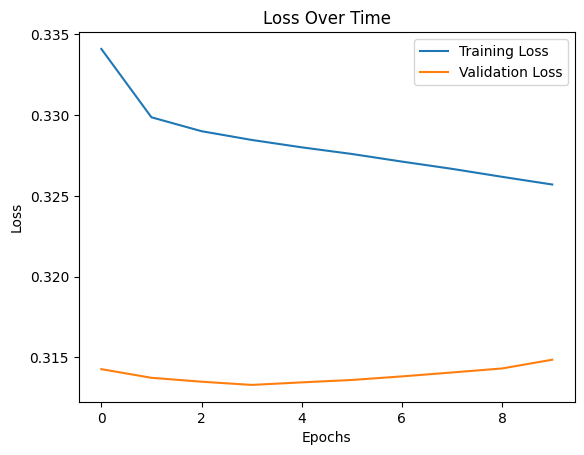

In [23]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_predictions_with_visualization(model, dataset, target_scaler, sample_size=200, evaluation_metrics=('mse', 'mae', 'rmse', 'r2')):
    """
    Evaluate the model predictions on a sample of the dataset using specified evaluation metrics and visualize the results.
    This function also plots the true values vs. the predicted values.

    Args:
        model: Trained model to evaluate.
        dataset: Dataset to evaluate the model on.
        target_scaler: Scaler used to transform the target variable.
        sample_size: Number of observations to sample from the dataset.
        evaluation_metrics: Tuple of evaluation metrics to compute. Supported metrics: 'mse', 'mae', 'rmse', 'r2'.

    Returns:
        Dictionary containing the evaluation results for each metric.
    """
    evaluation_results = {}
    predictions = []
    true_values = []

    # Sample a subset of the dataset
    dataset = dataset.take(sample_size)

    for x, y_true in dataset:
        y_pred = model.predict(x)
        predictions.append(y_pred)
        true_values.append(y_true)

    # Flatten the predictions and true values for evaluation and visualization
    predictions = np.vstack(predictions).flatten()
    true_values = np.vstack(true_values).flatten()

    # Inverse transform the predictions and true values to original scale
    predictions_original_scale = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    true_values_original_scale = target_scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()

    # Calculate each specified metric on the original scale
    if 'mse' in evaluation_metrics:
        mse = tf.keras.losses.MeanSquaredError()(true_values_original_scale, predictions_original_scale).numpy()
        evaluation_results['mse'] = mse
    if 'mae' in evaluation_metrics:
        mae = tf.keras.losses.MeanAbsoluteError()(true_values_original_scale, predictions_original_scale).numpy()
        evaluation_results['mae'] = mae
    if 'rmse' in evaluation_metrics:
        rmse = np.sqrt(tf.keras.losses.MeanSquaredError()(true_values_original_scale, predictions_original_scale).numpy())
        evaluation_results['rmse'] = rmse
    if 'r2' in evaluation_metrics:
        r2 = r2_score(true_values_original_scale, predictions_original_scale)
        evaluation_results['r2'] = r2

    # Print the metrics for the user
    for metric, value in evaluation_results.items():
        print(f"{metric.upper()}: {value:.4f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(true_values_original_scale, label='True Values', alpha=0.7)
    plt.plot(predictions_original_scale, label='Predictions', alpha=0.7)
    plt.title('Comparison of Predictions and True Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return evaluation_results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

2024-06-16 11:58:48.547553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


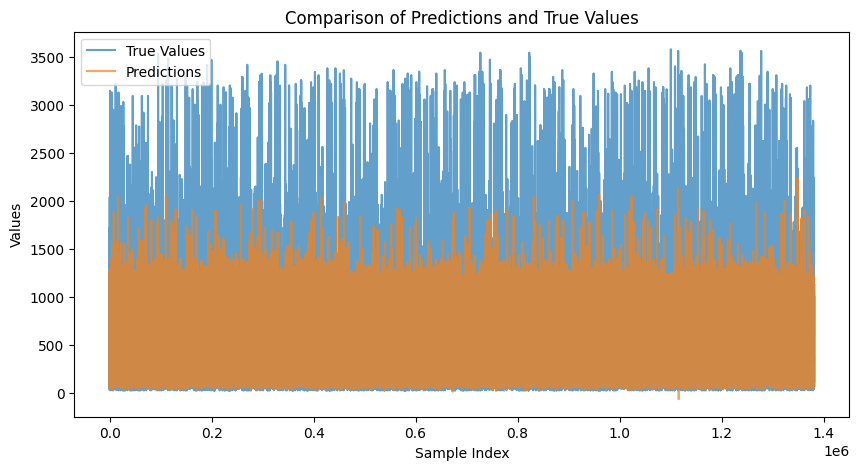

In [26]:
# Evaluate and visualize
results = evaluate_predictions_with_visualization(model, test_data2,window_generator.target_scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

2024-06-16 12:01:47.627247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


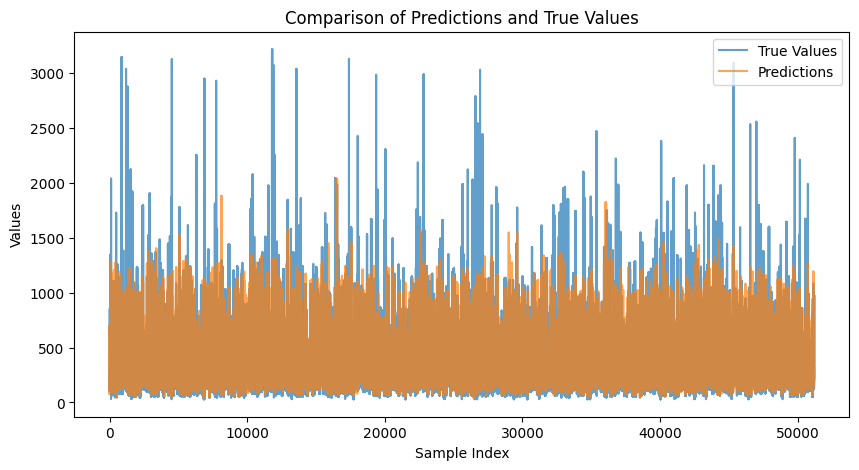

In [28]:
# Evaluate and visualize
results = evaluate_predictions_with_visualization(model, test_data2,window_generator.target_scaler)


## The enhanced LSTM

In [20]:
model = create_ts_bilstm_model(input_shape=(8, 14), units=128, learning_rate=0.001, dropout_rate=0.3)
history = train_model(model, train_data2, val_data2, epochs=15, batch_size=32)


Epoch 1/15


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-18 12:31:02.210243: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369910464 exceeds 10% of free system memory.
2024-06-18 12:31:02.400715: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26422176 exceeds 10% of free system memory.


25803/25803 ━━━━━━━━━━━━━━━━━━━━ 481s 18ms/step - loss: 0.3853 - mae: 0.2913 - val_loss: 0.3192 - val_mae: 0.2569 - learning_rate: 0.0010
Epoch 2/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 469s 18ms/step - loss: 0.3670 - mae: 0.2728 - val_loss: 0.3176 - val_mae: 0.2602 - learning_rate: 0.0010
Epoch 3/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 456s 18ms/step - loss: 0.3652 - mae: 0.2707 - val_loss: 0.3160 - val_mae: 0.2555 - learning_rate: 0.0010
Epoch 4/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 459s 18ms/step - loss: 0.3642 - mae: 0.2697 - val_loss: 0.3153 - val_mae: 0.2493 - learning_rate: 0.0010
Epoch 5/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 459s 18ms/step - loss: 0.3636 - mae: 0.2691 - val_loss: 0.3151 - val_mae: 0.2492 - learning_rate: 0.0010
Epoch 6/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 503s 18ms/step - loss: 0.3626 - mae: 0.2686 - val_loss: 0.3147 - val_mae: 0.2478 - learning_rate: 0.0010
Epoch 7/15
25803/25803 ━━━━━━━━━━━━━━━━━━━━ 499s 18ms/step - loss: 0.3620 - mae: 0.2682 - val_loss: 0.3158 - val_mae:

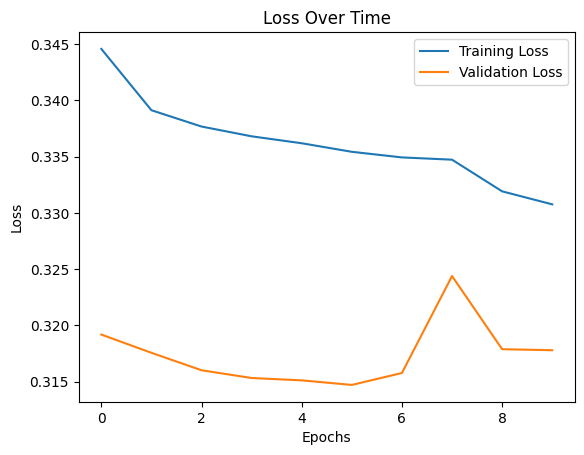

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

2024-06-18 14:00:33.315873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


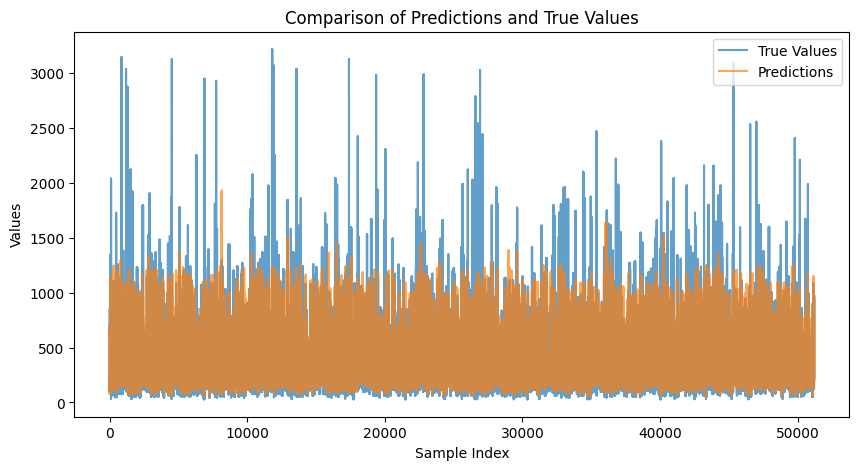

In [22]:
# Evaluate and visualize
results = evaluate_predictions_with_visualization(model, test_data2,window_generator.target_scaler,sample_size=200)
